In [926]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.optim as optim

In [927]:
class NBADataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = self._load_data()

    def _load_data(self):
        df = pd.read_csv(self.file_path, index_col=0)
        return df

    def _add_target(self, group):
        group = pd.concat([group, group["won"].shift(-1).rename("target")], axis=1)
        return group

    def _scale_data(self, df, selected_columns):
        scaler = MinMaxScaler()
        df[selected_columns] = scaler.fit_transform(df[selected_columns])
        return df

    def _calculate_rolling_averages(self, df, selected_columns):
        rolling = df[list(selected_columns) + ["won", "team", "season"]]
        
        def find_team_averages(team):
            team[selected_columns] = team[selected_columns].rolling(10).mean()
            return team

        rolling = rolling.groupby(["team", "season"], group_keys=False).apply(find_team_averages)

        return rolling

    def _add_future_game_data(self, df):
        def shift_col(team, col_name):
            next_col = team[col_name].shift(-1)
            return next_col

        df["home_next"] = self._add_col(df, "home")
        df["team_opp_next"] = self._add_col(df, "team_opp")
        df["date_next"] = self._add_col(df, "date")

        return df

    def _add_col(self, df, col_name):
        return df.groupby("team", group_keys=False).apply(lambda x: self._shift_col(x, col_name))

    def _shift_col(self, team, col_name):
        next_col = team[col_name].shift(-1)
        return next_col

    def prepare_dataset(self):
        # Sort by date and drop irrelevant columns
        self.df = self.df.sort_values("date")
        self.df = self.df.reset_index(drop=True)
        del self.df["mp.1"]
        del self.df["mp_opp.1"]
        del self.df["index_opp"]

        #Add a target column (Whether or not team won next game)
        self.df = self.df.groupby("team", group_keys=False).apply(self._add_target)
        self.df.loc[pd.isnull(self.df["target"]), "target"] = 2
        self.df["target"] = self.df["target"].astype(int, errors="ignore")
        
        #Create copy dataframe without null values
        nulls = pd.isnull(self.df).sum()
        nulls = nulls[nulls > 0]
        valid_columns = self.df.columns[~self.df.columns.isin(nulls.index)]
        self.df = self.df[valid_columns].copy()
        
        #Convert boolean column to binary
        self.df['won'] = self.df['won'].astype(int)
        
        #Scale stat columns
        removed_columns = ["season", "date", "won", "target", "team", "team_opp"]
        selected_columns = self.df.columns[~self.df.columns.isin(removed_columns)]
        self.df = self._scale_data(self.df, selected_columns)
        rolling = self._calculate_rolling_averages(self.df, selected_columns)
        
        rolling_cols = [f"{col}_10" for col in rolling.columns]
        rolling.columns = rolling_cols
        
        #Concatenate new columns back into dataframe, dropping null and resetting index
        self.df = pd.concat([self.df, rolling], axis=1)
        self.df = self.df.dropna()
        self.df = self.df.reset_index(drop=True)

        #Add future game data to columns
        self.df = self._add_future_game_data(self.df)
        
        self.df = self.df.merge(self.df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])

        return self.df
    
    def _extract_features(self, df):
        
        # # Extract features for team_x and team_opp_next_x
        # team_x_cols = [col for col in df.columns if '_10_x' in col and 'opp' not in col]
        # team_opp_next_x_cols = [col for col in df.columns if 'opp_10_x' in col]

        # # Concatenate features and rolling averages, including home_next
        # features_columns = team_x_cols + team_opp_next_x_cols + ["home_next"]
        
        removed_columns = list(self.df.columns[self.df.dtypes == "object"])
        selected_columns = self.df.columns[~self.df.columns.isin(removed_columns)]
        
        # Exclude columns with specific words
        excluded_words = ["season", "date", "won", "target", "team", "team_opp"]
        features_columns = [col for col in selected_columns if not any(word in col for word in excluded_words)]
        # features_columns = [col for col in features_columns if not any(word in col for word in excluded_words)]
        
        features_df = df[features_columns].copy()

        return features_df
    
class NBADataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.target[idx], dtype=torch.float32)
        return x, y
    
# def load_data(processed_df, data_processor):
#     season_df = processed_df[["season", "target"]].copy()

#     # Extract features and target using the _extract_features method
#     features_df = data_processor._extract_features(processed_df)

#     # Concatenate season and date columns back to features dataframe
#     features_df = pd.concat([season_df, features_df], axis=1)

#     # Define features and target
#     target_column = "target"

#     # Define features and target
#     features_columns = [col for col in features_df.columns if col not in ["season", "target"]]

#     # Extract features and target for training and testing sets
#     features = features_df[features_columns].values
#     target = features_df[target_column].values

#     return features, target, features_columns, features_df



In [928]:
class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
    
def plot_loss(loss_values, title="Training Loss"):
    plt.plot(loss_values, marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def plot_accuracy(accuracy_values, title="Training Accuracy"):
    plt.plot(accuracy_values, marker='o', color='green')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.show()
    

# def train_model(features, target, features_columns, num_epochs=20, learning_rate=0.001):
#     # Create DataLoader for training
#     dataset = NBADataset(features, target)
#     dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#     # Initialize and train the model
#     input_size = len(features_columns)
#     net = SimpleNet(input_size=input_size)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     net.to(device)

#     criterion = torch.nn.BCELoss()
#     optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

#     # Perform time-based cross-validation
#     tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

#     loss_values = []  # To store the loss for each epoch
#     accuracy_values = []  # To store the accuracy for each epoch

#     for epoch in range(num_epochs):
#         net.train()
#         total_correct = 0
#         total_examples = 0
#         epoch_loss = 0.0

#         for train_index, _ in tscv.split(features):
#             train_features, train_target = features[train_index], target[train_index]
#             train_dataset = NBADataset(train_features, train_target)
#             train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#             for inputs, labels in train_dataloader:
#                 inputs, labels = inputs.to(device), labels.to(device)

#                 optimizer.zero_grad()

#                 outputs = net(inputs)
#                 loss = criterion(outputs, labels.unsqueeze(1))

#                 # Calculate accuracy
#                 predictions = (outputs > 0.5).float()
#                 correct = (predictions == labels.unsqueeze(1)).float().sum()
#                 total_correct += correct
#                 total_examples += labels.size(0)

#                 loss.backward()
#                 optimizer.step()

#                 epoch_loss += loss.item()

    #     # Learning rate scheduling
    #     if epoch % 5 == 0:
    #         for param_group in optimizer.param_groups:
    #             param_group['lr'] *= 0.9  # Reduce learning rate by 10% every 5 epochs

    #     # Calculate accuracy and loss for the epoch
    #     accuracy = (total_correct / total_examples) * 100.0
    #     average_loss = epoch_loss / len(train_dataloader)

    #     # Store loss and accuracy values
    #     loss_values.append(average_loss)
    #     accuracy_values.append(accuracy)

    #     # Print the loss and accuracy for each epoch
    #     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # return net, loss_values, accuracy_values
    
    
# Function to perform backtesting
def backtest(model, data, predictors, start=0, step=1):

    seasons = sorted(data["season"].unique())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    for i in range(start, len(seasons), step):
        season = seasons[i]
        #train_df = data[data["season"] < season]
        test_df = data[data["season"] == season]
        
        target_column = "target"

        #Extract features
        test_features = test_df[predictors].values
        test_target = test_df[target_column].values

        test_dataset = NBADataset(test_features, test_target)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model.eval()  # Set the model to evaluation mode
        
        with torch.no_grad():
            correct = 0
            total = 0

            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                predicted = torch.round(outputs)

                total += labels.size(0)
                correct += (predicted == labels.unsqueeze(1)).sum().item()
                

        accuracy = correct / total
        print(f"Season {season} Accuracy: {accuracy * 100:.2f}%")
    

In [929]:
# Specify the relative path to the dataset
relative_path = 'datasets/nba_games.csv'
read_file = os.path.join(os.getcwd(), relative_path)

In [930]:
# Initialize NBADataProcessor and prepare the dataset
data_processor = NBADataProcessor(file_path=read_file)
processed_df = data_processor.prepare_dataset()

In [931]:
# # Load the data
# features, target, features_columns, features_df = load_data(processed_df, data_processor)

In [932]:
# # Train the model
# model, losses, accuracies = train_model(features, target, features_columns)

In [933]:
season_df = processed_df[["season", "target"]].copy()

# Extract features and target using the _extract_features method
features_df = data_processor._extract_features(processed_df)

# Concatenate season and date columns back to features dataframe
features_df = pd.concat([season_df, features_df], axis=1)

# Define features and target
target_column = "target"

# Define features and target
features_columns = [col for col in features_df.columns if col not in ["season", "target"]]

#Separate validation set

# Identify the cutoff season (e.g., 2022)
cutoff_season = 2022

# # Divide the data into training and testing sets
train_df = features_df[features_df["season"] < cutoff_season]
test_df = features_df[features_df["season"] == cutoff_season]

# Extract features and target for testing set
test_features = test_df[features_columns].values
test_target = test_df[target_column].values

# Create DataLoader for testing
test_dataset = NBADataset(test_features, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract features and target for training and testing sets
train_features = train_df[features_columns].values
train_target = train_df[target_column].values

# # Create DataLoader for training
train_dataset = NBADataset(train_features, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [934]:
# Initialize and train the model
input_size = len(features_columns)
net = SimpleNet(input_size=input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

# Perform time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Training loop
num_epochs = 20

loss_values = []  # To store the loss for each epoch
accuracy_values = []  # To store the accuracy for each epoch

In [935]:
for epoch in range(num_epochs):
    net.train()
    total_correct = 0
    total_examples = 0
    epoch_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct = (predictions == labels.unsqueeze(1)).float().sum()
        total_correct += correct
        total_examples += labels.size(0)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Learning rate scheduling
    if epoch % 5 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.9  # Reduce learning rate by 10% every 5 epochs

    # Calculate accuracy and loss for the epoch
    accuracy = (total_correct / total_examples) * 100.0
    average_loss = epoch_loss / len(train_dataloader)

    # Store loss and accuracy values
    loss_values.append(average_loss)
    accuracy_values.append(accuracy)

    # Print the loss and accuracy for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/20, Loss: 0.6609, Accuracy: 61.12%
Epoch 2/20, Loss: 0.6370, Accuracy: 63.89%
Epoch 3/20, Loss: 0.6294, Accuracy: 64.56%
Epoch 4/20, Loss: 0.6264, Accuracy: 65.10%
Epoch 5/20, Loss: 0.6245, Accuracy: 65.20%
Epoch 6/20, Loss: 0.6209, Accuracy: 65.89%
Epoch 7/20, Loss: 0.6163, Accuracy: 66.14%
Epoch 8/20, Loss: 0.6126, Accuracy: 66.86%
Epoch 9/20, Loss: 0.6109, Accuracy: 66.74%
Epoch 10/20, Loss: 0.6075, Accuracy: 67.13%
Epoch 11/20, Loss: 0.6060, Accuracy: 67.50%
Epoch 12/20, Loss: 0.5974, Accuracy: 68.33%
Epoch 13/20, Loss: 0.5997, Accuracy: 67.83%
Epoch 14/20, Loss: 0.5909, Accuracy: 68.51%
Epoch 15/20, Loss: 0.5897, Accuracy: 68.41%
Epoch 16/20, Loss: 0.5881, Accuracy: 69.11%
Epoch 17/20, Loss: 0.5825, Accuracy: 69.06%
Epoch 18/20, Loss: 0.5802, Accuracy: 69.72%
Epoch 19/20, Loss: 0.5755, Accuracy: 69.90%
Epoch 20/20, Loss: 0.5714, Accuracy: 70.13%


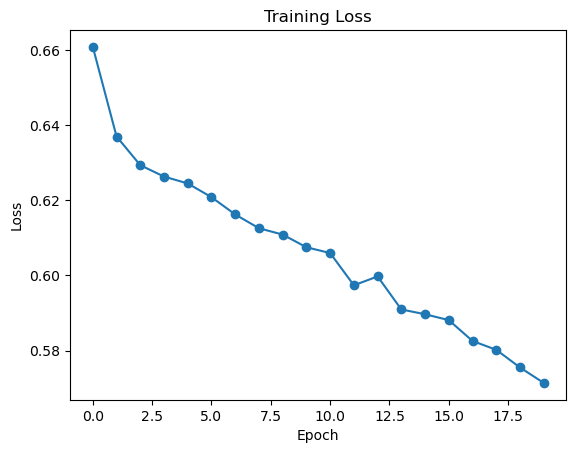

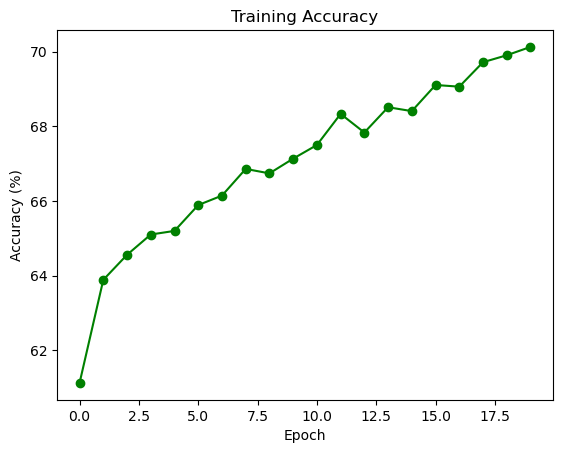

In [936]:
# Plot loss and accuracy
plot_loss(loss_values)
plot_accuracy(accuracy_values)
# # Plot loss and accuracy
# plot_loss(losses)
# plot_accuracy(accuracies)

In [937]:
# Perform backtesting at each epoch
backtest(net, features_df, features_columns)

Season 2016 Accuracy: 74.43%
Season 2017 Accuracy: 72.75%
Season 2018 Accuracy: 74.29%
Season 2019 Accuracy: 74.79%
Season 2020 Accuracy: 72.88%
Season 2021 Accuracy: 72.50%
Season 2022 Accuracy: 61.26%


In [938]:
# Evaluation on testing data
net.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        predicted = torch.round(outputs)

        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

        # Collect labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 61.26%


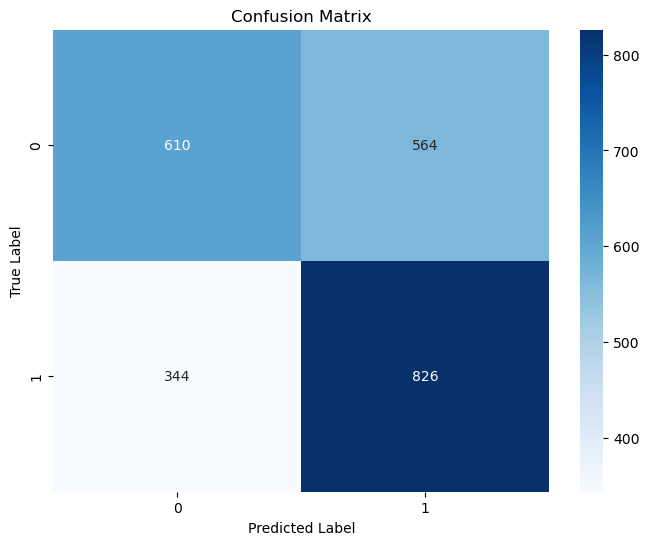

In [939]:
# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [940]:
torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': average_loss,
    }, 'nba_model.pth')